## Object Detection с помощью Microsoft Custom Vision


Попробуем обучить модель Custom Vision для распознавания головы человека на фотографии. Для этого будем использовать подмножество датасета [Hollywood Heads](https://www.di.ens.fr/willow/research/headdetection/) из 1000 изображений

In [3]:
!wget https://raw.githubusercontent.com/shwars/NeuroWorkshopData/master/Data/HollywoodHeadsSmall.zip
!unzip -q HollywoodHeadsSmall
!rm HollywoodHeadsSmall.zip

--2018-12-04 11:28:23--  https://raw.githubusercontent.com/shwars/NeuroWorkshopData/master/Data/HollywoodHeadsSmall.zip
Resolving webproxy (webproxy)... 10.36.45.1
Connecting to webproxy (webproxy)|10.36.45.1|:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 33426403 (32M) [application/zip]
Saving to: ‘HollywoodHeadsSmall.zip’

HollywoodHeadsSmall 100%[===================>]  31.88M  2.51MB/s    in 13s     

2018-12-04 11:28:37 (2.42 MB/s) - ‘HollywoodHeadsSmall.zip’ saved [33426403/33426403]



Для каждого изображения в датасете присутствует .xml-файл с описанием встречающихся в нём объектов:

In [7]:
!ls HollywoodHeadsSmall | tail -6

mov_020_143015.jpeg
mov_020_143015.xml
mov_021_061514.jpeg
mov_021_061514.xml
mov_021_149390.jpeg
mov_021_149390.xml


In [8]:
!cat HollywoodHeadsSmall/mov_021_149390.xml

<annotation>
	<folder>HollywoodHeads</folder>
	<filename>mov_021_149390.jpeg</filename>
	<source>
		<database>HollywoodHeads 2015 Database</database>
		<annotation>HollywoodHeads 2015</annotation>
		<image>WILLOW</image>
	</source>
	<size>
		<width>608</width>
		<height>320</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>head</name>
		<bndbox>
			<xmin>201</xmin>
			<ymin>1</ymin>
			<xmax>480</xmax>
			<ymax>263</ymax>
		</bndbox>
		<difficult>0</difficult>
	</object>
	<object>
		<name>head</name>
		<bndbox>
			<xmin>3</xmin>
			<ymin>4</ymin>
			<xmax>241</xmax>
			<ymax>285</ymax>
		</bndbox>
		<difficult>0</difficult>
	</object>
</annotation>


Для работы с изображениями нам также понадобится OpenCV:

In [1]:
!pip install opencv-python
import cv2

In [52]:
import os, time

## Библиотека mPyPl

Для работы с потоками данных удобно использовать библиотеку [mPyPl](http://github.com/shwars/mPyPl). Например, мы можем легко прочитать все XML-описания изображений в виде потока:

In [18]:
import sys
!{sys.executable} -m pip install mPyPl==0.0.3.1

  Found existing installation: mPyPl 0.0.3
    Uninstalling mPyPl-0.0.3:
      Successfully uninstalled mPyPl-0.0.3


In [2]:
import mPyPl as mp
from mPyPl.utils.image import show_images
from pipe import *
from mPyPl.utils.pipeutils import *

Посмотрим, как выглядят первые несколько изображений с bounding box-ами:

In [5]:
data = mp.get_pascal_annotations('HollywoodHeadsSmall') | as_list

In [8]:
data[4]

{'folder': 'HollywoodHeads',
 'filename': 'mov_012_063018.jpeg',
 'source': {'database': 'HollywoodHeads 2015 Database',
  'annotation': 'HollywoodHeads 2015',
  'image': 'WILLOW'},
 'size_width': '548',
 'size_height': '226',
 'size_depth': '3',
 'segmented': '0',
 'object': [{'name': 'head',
   'bndbox_xmin': '340',
   'bndbox_ymin': '20',
   'bndbox_xmax': '397',
   'bndbox_ymax': '81',
   'difficult': '0'},
  {'name': 'head',
   'bndbox_xmin': '80',
   'bndbox_ymin': '63',
   'bndbox_xmax': '119',
   'bndbox_ymax': '112',
   'difficult': '0'}]}

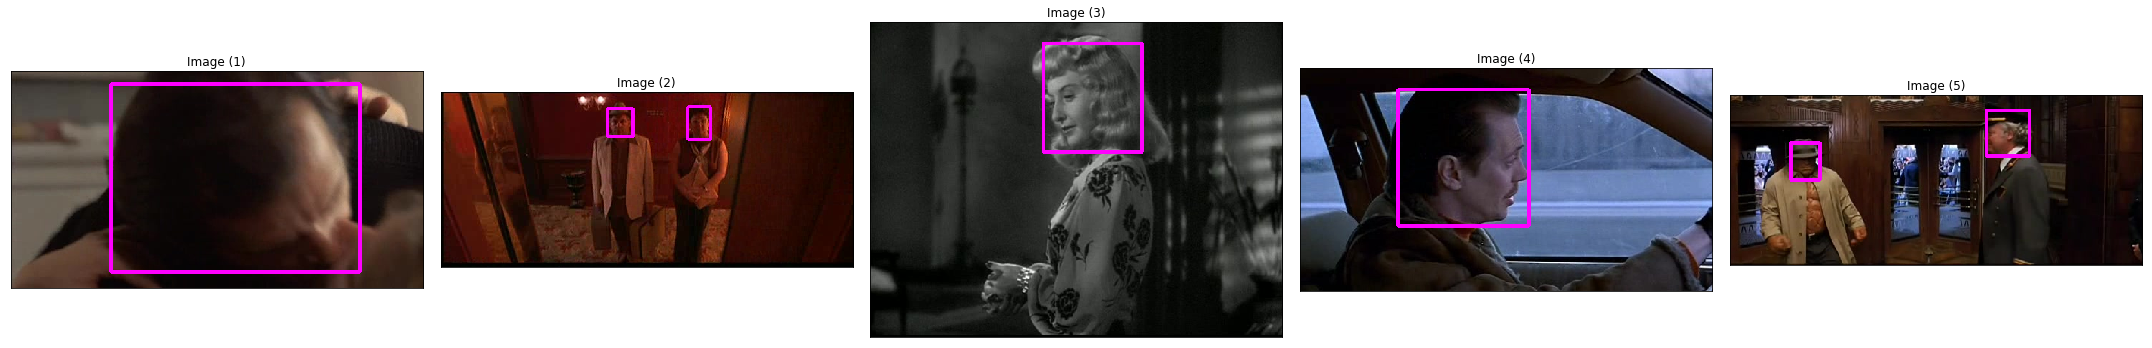

In [32]:
dat = (data | take(5) | mp.apply('filename','img',lambda x: cv2.imread('HollywoodHeadsSmall/'+x)) 
            | mp.sapply('img',lambda x: cv2.cvtColor(x,cv2.COLOR_BGR2RGB)))

def imprint(arg):
    for x in arg[1]:
        cv2.rectangle(arg[0],(x.as_int('bndbox_xmin'),x.as_int('bndbox_ymin')),(x.as_int('bndbox_xmax'),x.as_int('bndbox_ymax')),(255,0,255),3)

(dat | mp.apply(['img','object'],None,imprint) | mp.select_field('img') | pexec(show_images))

## Подключаемся к Custom Vision

Процесс обучения object detection для Custom Vision описан в [официальной документации](https://docs.microsoft.com/en-us/azure/cognitive-services/custom-vision-service/python-tutorial-od).

Для доступа к Custom Vision необходимы ключи. Кроме того, необходимо установить SDK.

In [41]:
training_key = "8e507de27fe045b2980e6a8b3fb82cd2"
prediction_key = "cf32b5ca5d1748a3bb378eb12ded1723"

In [36]:
!pip install azure-cognitiveservices-vision-customvision

    100% |████████████████████████████████| 102kB 4.4MB/s a 0:00:011


In [39]:
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateEntry, Region

In [43]:
trainer = CustomVisionTrainingClient(training_key,endpoint="https://southcentralus.api.cognitive.microsoft.com")

In [56]:
obj_detection_domain = next(domain for domain in trainer.get_domains() if domain.type == "ObjectDetection")
project = trainer.create_project("Temp", domain_id=obj_detection_domain.id)
project_id = project.id
tag_id = trainer.create_tag(project_id,"head")

In [57]:
def process_objects(x):
    w,h,o = x
    w,h = float(w),float(h)
    r = []
    for i,x in enumerate(o):
        if x['difficult'] == '1':
            continue
        lw = x.as_float('bndbox_xmax')-x.as_float('bndbox_xmin')
        lh = x.as_float('bndbox_ymax')-x.as_float('bndbox_ymin')
        dx = x.as_float('bndbox_xmin') / w
        dy = x.as_float('bndbox_xmin') / w
        dw = lw / w
        dh = lh / w
        r.append(Region(left=dx,top=dy,width=dw,height=dh,tag_id=tag_id.id))
    return r

def read_file(fn):
    return open(fn,'rb').read()

In [58]:
data1 = (data
         | mp.apply(['size_width','size_height','object'],'regions',process_objects)
         | mp.apply('filename','content',lambda x: read_file(os.path.join('HollywoodHeadsSmall',x)))
         | mp.apply(['filename','content','regions'],'ifce',lambda x: ImageFileCreateEntry(name=x[0],contents=x[1],regions=x[2]))
         | mp.select_field('ifce')
         )

for x in data1 | take(1000) | mp.pbatch(10):
    res = trainer.create_images_from_files(project_id, x)
    print("Success: {}".format(res.is_batch_successful))


Success: True
Success: True
Success: True
Success: True
Success: True
Success: True
Success: True
Success: True
Success: True
Success: True
Success: True
Success: True
Success: True
Success: True
Success: True
Success: True
Success: True
Success: True
Success: True
Success: True
Success: True
Success: True
Success: True
Success: True
Success: True
Success: True
Success: True
Success: True
Success: True
Success: True
Success: True
Success: True
Success: True
Success: True
Success: True
Success: True
Success: True
Success: True
Success: True
Success: True
Success: True
Success: True
Success: True
Success: True
Success: True
Success: True


TypeError: string indices must be integers

In [ ]:
print ("Training...")
iteration = trainer.train_project(project_id=project_id)
while (iteration.status != "Completed"):
    iteration = trainer.get_iteration(project.id, iteration.id)
    print ("Training status: " + iteration.status)
    time.sleep(1)

# The iteration is now trained. Make it the default project endpoint
trainer.update_iteration(project_id, iteration.id, is_default=True)

Training...
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
